In [1]:
import pandas as pd

In [1]:
import gensim
import numpy as np
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors

/Users/Taras_Ustyianovych/workspace/python-envs/tg-data-research/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Define constants with vector sizes
WORD_VECTOR_SIZE = 300
DOCUMENT_VECTOR_SIZE = 300

In [17]:
# df = pd.read_parquet('data/posts_reactions_df.parquet')
full_text_df = pd.read_parquet('data/all_collected_text_data_processed.parquet')

corpus = full_text_df['lemmatized_text_filtered'].to_list()

In [18]:
len(corpus)

5730

In [19]:
corpus = [item for item in corpus if len(item) > 0]

In [20]:
len(corpus)

5730

#### Data analysis to set optimal fastText model hyperparameters

In [11]:
print("mean:", np.mean(full_text_df['lemmatized_text_filtered_word_count']))
print("median:", np.median(full_text_df['lemmatized_text_filtered_word_count']))
print("25th percentile:", np.percentile(full_text_df['lemmatized_text_filtered_word_count'], 25))
print("75th percentile:", np.percentile(full_text_df['lemmatized_text_filtered_word_count'], 75))
print("90th percentile:", np.percentile(full_text_df['lemmatized_text_filtered_word_count'], 90))
print("95th percentile:", np.percentile(full_text_df['lemmatized_text_filtered_word_count'], 95))
print("99th percentile:", np.percentile(full_text_df['lemmatized_text_filtered_word_count'], 99))

mean: 61.23831123517097
median: 46.0
25th percentile: 29.0
75th percentile: 73.0
90th percentile: 124.0
95th percentile: 165.0
99th percentile: 291.0


In [51]:
print("mean:", np.mean(df['lemmatized_text_filtered_word_count']))
print("median:", np.median(df['lemmatized_text_filtered_word_count']))
print("25th percentile:", np.percentile(df['lemmatized_text_filtered_word_count'], 25))
print("75th percentile:", np.percentile(df['lemmatized_text_filtered_word_count'], 75))
print("90th percentile:", np.percentile(df['lemmatized_text_filtered_word_count'], 90))
print("95th percentile:", np.percentile(df['lemmatized_text_filtered_word_count'], 95))
print("99th percentile:", np.percentile(df['lemmatized_text_filtered_word_count'], 99))

mean: 62.916968277624015
median: 48.0
25th percentile: 30.0
75th percentile: 74.0
90th percentile: 127.0
95th percentile: 168.0
99th percentile: 294.0799999999999


#### Build custom fastText model with embedding size 64

In [30]:
# Tokenize and preprocess the text data
def preprocess_text(text):
    return text.lower().split()

# Tokenize and preprocess the training data
tokenized_corpus = [preprocess_text(text) for text in corpus]

In [21]:
print(len(corpus))
print(len(tokenized_corpus))

5730
5730


In [22]:
# Define constants with vector sizes
WORD_VECTOR_SIZE = 64
DOCUMENT_VECTOR_SIZE = 64


# Train the FastText model
fasttext_model = FastText(vector_size=WORD_VECTOR_SIZE, window=10, min_count=3, sg=1, workers=8)
fasttext_model.build_vocab(corpus_iterable=tokenized_corpus)
fasttext_model.train(corpus_iterable=tokenized_corpus, total_examples=len(tokenized_corpus), epochs=20)

fasttext_model.save("../fast-text-custom-model-full-climate-text/cc.uk.64.full.climate.text.custom.bin"

KeyboardInterrupt: 

In [76]:
fasttext_model = FastText.load("../fast-text-custom-model-full-climate-text/cc.uk.64.full.climate.text.custom.bin")

#### Load the BERTopic model (trained in eda.ipynb with the FastText model)

In [ ]:
from bertopic import BERTopic
import json
bertopic_model = BERTopic.load('bertopic-model/bertopic-fasttext64-custom-embeddings-all-data/')
bertopic_data = pd.read_parquet('all-data-feb-2025-bertopic-topics-on-reactions-corpus-merged.parquet')

In [26]:
topic_list_df = pd.DataFrame(bertopic_model.topics_, columns = ['Topic'])
topic_info_df = pd.merge(topic_list_df, bertopic_data[['Topic', 'Primary Topic', 'Secondary Topic']], on='Topic', how='left')

In [29]:
primary_topic_factor, primary_topic_mapping = topic_info_df['Primary Topic'].factorize()
secondary_topic_factor, secondary_topic_mapping = topic_info_df['Secondary Topic'].factorize()

In [59]:
channel_factor, mapping = df['channel_name'].factorize()

In [60]:
channel_factor

array([0, 0, 0, ..., 6, 6, 6])

In [61]:
len(channel_factor)

4697

In [9]:
df['lemmatized_text_filtered_word_count'] = df['lemmatized_text_filtered'].apply(lambda x: len(x.split()))
full_text_df['lemmatized_text_filtered_word_count'] = full_text_df['lemmatized_text_filtered'].apply(lambda x: len(x.split()))

### Vectorization method #1 - Averaging of word embeddings

In [77]:
# Tokenize and preprocess the text data
def preprocess_text(text):
    return text.lower().split()

# Tokenize and preprocess the training data
tokenized_corpus = [preprocess_text(text) for text in corpus]

In [78]:
tokenized_corpus[0]

['південнокорейський',
 'пусан',
 'завершитися',
 'переговори',
 'представник',
 '170',
 'країна',
 'світ',
 'укладання',
 'договір',
 'боротьба',
 'пластиковий',
 'забруднення',
 'угода',
 'вдатися',
 'досягти',
 'вирішити',
 'продовжити',
 'переговори',
 'наступний',
 'рок']

In [79]:
len(fasttext_model.wv[tokenized_corpus[0][0]])

64

In [80]:
len(tokenized_corpus)

5730

In [81]:
# Create document vectors using fastText model
docVec = []

for i in range(len(tokenized_corpus)):
    # print(i)
    wordVectors = fasttext_model.wv[tokenized_corpus[i]]
    docVecEntity = np.add(0, wordVectors.sum(axis=0))
    docVecResult = np.divide(docVecEntity, len(tokenized_corpus[i]))

    docVec.append(docVecResult)

In [82]:
len(docVec[0])

64

In [83]:
len(docVec)

5730

### Perform PCA and t-SNE (word embedding size = 300)

In [58]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

In [11]:
# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(docVec)

/var/folders/mc/36xkpyzx5hn6t7wmy23pdz5c0000gn/T/ipykernel_5199/1673630353.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='tab10', s=1)


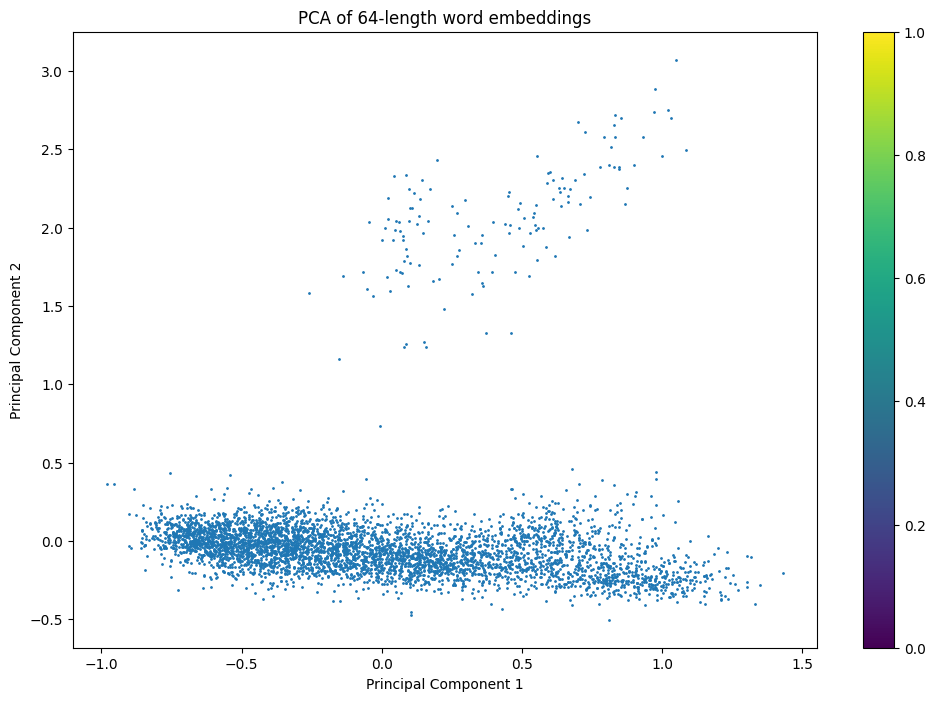

In [12]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='tab10', s=1)
plt.colorbar(scatter)
plt.title('PCA of 64-length word embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [66]:
np.array(docVec).shape

(4697, 300)

In [41]:
docVec[0]

array([-0.11398246, -0.05407755, -0.0395888 ,  0.00432219,  0.09868572,
       -0.38721204,  0.04792277,  0.19804719,  0.23653662, -0.0886881 ,
        0.2752028 , -0.2738605 ,  0.43605432,  0.24411353, -0.01377159,
       -0.11474415,  0.01766744, -0.15628254, -0.19578382, -0.35249546,
       -0.3535441 ,  0.22104338, -0.0242388 , -0.14985393, -0.16753635,
        0.43063563, -0.0205884 , -0.07415625,  0.2972313 , -0.28259853,
       -0.27661788, -0.14643809, -0.25865674,  0.24178264, -0.0292215 ,
        0.30949506, -0.17867744, -0.3070066 , -0.17107993, -0.07682959,
        0.24180786,  0.2639441 , -0.17880842,  0.18009952,  0.5124175 ,
        0.06769498,  0.18006596,  0.23946501, -0.06500625,  0.21600746,
       -0.08354735,  0.11264652,  0.2463557 ,  0.5462702 , -0.5315711 ,
       -0.03218952, -0.35798806,  0.02337374, -0.01970946, -0.13412309,
       -0.2919694 ,  0.21267153, -0.20406042, -0.44901118], dtype=float32)

In [43]:
docVec[0][:2]

array([-0.11398246, -0.05407755], dtype=float32)

In [44]:
len(docVec)

4697

In [23]:
tsne.kl_divergence_

1.5805976390838623

In [67]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(np.array(docVec))

In [45]:
tsne.kl_divergence_

1.4416897296905518

### Perform PCA and t-SNE (word embedding size = 64)

In [10]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

In [13]:
# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(docVec)

/var/folders/mc/36xkpyzx5hn6t7wmy23pdz5c0000gn/T/ipykernel_5199/1673630353.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='tab10', s=1)


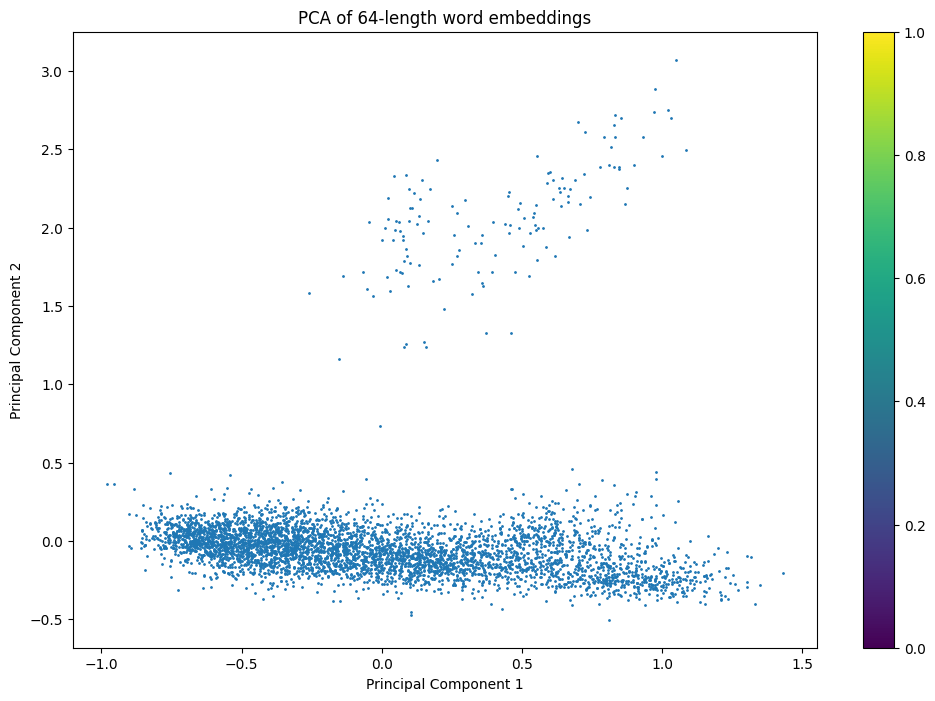

In [14]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='tab10', s=1)
plt.colorbar(scatter)
plt.title('PCA of 64-length word embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [24]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=2500, random_state=42)
tsne_result = tsne.fit_transform(np.array(docVec))
print(tsne.kl_divergence_)

1.5375440120697021


### Hyperparameter optimization for embedding size 64 (full text)

In [50]:
import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
from sklearn.manifold import TSNE
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Sample data - replace this with your actual data
# For example, np.array(docVec) if you have docVec defined

# Define the space of hyperparameters to search
space  = [Integer(5, 80, name='perplexity'),  # Perplexity range
          Integer(300, 8000, name='n_iter')]  # Number of iterations range

# Objective function to minimize
@use_named_args(space)
def objective(**params):
    tsne = TSNE(n_components=2, random_state=42, **params)
    X_tsne = tsne.fit_transform(np.array(docVec))
    return tsne.kl_divergence_

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# Best hyperparameters and corresponding KL Divergence
print("Best parameters: {}".format(res_gp.x))
print("Best KL Divergence: {:.5f}".format(res_gp.fun))

Best parameters: [80, 8000]
Best KL Divergence: 1.41205


In [101]:
res_gp.func_vals

array([1.50905406, 1.44467413, 1.50670624, 1.68371868, 1.60473752,
       1.45747161, 1.57053256, 1.58413529, 1.5704689 , 1.61966169,
       1.41204953, 1.42510641, 1.41421366, 1.41691756, 1.41264021,
       1.56263256, 1.42085552, 1.41333008, 1.41232872, 1.63176656,
       1.41524136, 1.4123466 , 1.41292977, 1.4137156 , 1.41219616,
       1.45357418, 1.41595876, 1.59236825, 1.43285465, 1.41248345,
       1.41212749, 1.44588411, 1.54800916, 1.42330003, 1.41465116,
       1.41227818, 1.41870713, 1.53383994, 1.44247341, 1.56071353,
       1.55317318, 1.48242092, 1.43939567, 1.43564022, 1.48837376,
       1.52469087, 1.68527031, 1.44416237, 1.49227333, 1.4938215 ])

In [103]:
res_gp.x_iters

[[49, 6801],
 [69, 6824],
 [52, 3260],
 [27, 737],
 [25, 3978],
 [66, 3996],
 [34, 6738],
 [30, 5291],
 [33, 7670],
 [16, 7000],
 [80, 8000],
 [80, 1391],
 [80, 4809],
 [80, 3130],
 [80, 6754],
 [80, 427],
 [80, 2208],
 [80, 5880],
 [80, 7323],
 [33, 919],
 [80, 4041],
 [80, 7339],
 [80, 6354],
 [80, 5352],
 [80, 7725],
 [70, 1762],
 [80, 3632],
 [5, 2379],
 [73, 7995],
 [80, 7053],
 [80, 7881],
 [69, 5468],
 [6, 7945],
 [80, 1706],
 [80, 4458],
 [80, 7553],
 [80, 2565],
 [5, 5072],
 [72, 2934],
 [41, 2155],
 [5, 3700],
 [66, 984],
 [71, 6110],
 [73, 4715],
 [55, 7998],
 [5, 6017],
 [5, 1277],
 [69, 7469],
 [55, 4743],
 [54, 5872]]

In [104]:
res_gp

          fun: 1.4120495319366455
            x: [80, 8000]
    func_vals: [ 1.509e+00  1.445e+00 ...  1.492e+00  1.494e+00]
      x_iters: [[49, 6801], [69, 6824], [52, 3260], [27, 737], [25, 3978], [66, 3996], [34, 6738], [30, 5291], [33, 7670], [16, 7000], [80, 8000], [80, 1391], [80, 4809], [80, 3130], [80, 6754], [80, 427], [80, 2208], [80, 5880], [80, 7323], [33, 919], [80, 4041], [80, 7339], [80, 6354], [80, 5352], [80, 7725], [70, 1762], [80, 3632], [5, 2379], [73, 7995], [80, 7053], [80, 7881], [69, 5468], [6, 7945], [80, 1706], [80, 4458], [80, 7553], [80, 2565], [5, 5072], [72, 2934], [41, 2155], [5, 3700], [66, 984], [71, 6110], [73, 4715], [55, 7998], [5, 6017], [5, 1277], [69, 7469], [55, 4743], [54, 5872]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        normalize_y=True, random_s

### Split by BERTopic Primary Topic Groups

In [86]:
primary_topic_factor
# secondary_topic_factor

array([0, 0, 0, ..., 3, 0, 3])

In [85]:
primary_topic_factor, primary_topic_mapping = full_text_df['Primary Topic'].factorize()

In [51]:
import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns

import numpy as np
from sklearn.manifold import TSNE
# from skopt import gp_minimize
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args

In [38]:
legeld_labels = [primary_topic_mapping[i] for i in primary_topic_factor]

In [87]:
primary_topic_mapping

Index(['Geopolitical & War Dynamics',
       'War-Related Environmental and Resource Impact', 'Miscellaneous',
       'Environmental and Climate Issues', 'Energy and Resources'],
      dtype='object')

In [88]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=80, n_iter=8000, random_state=42)
tsne_result = tsne.fit_transform(np.array(docVec))
print(tsne.kl_divergence_)

/Users/Taras_Ustyianovych/workspace/python-envs/tg-data-research/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


1.4114954471588135


In [89]:
for index, i in enumerate(primary_topic_mapping):
    print(index, i)

0 Geopolitical & War Dynamics
1 War-Related Environmental and Resource Impact
2 Miscellaneous
3 Environmental and Climate Issues
4 Energy and Resources


In [90]:
primary_topic_mapping_dict = {
    0: 'Geopolitical & War Dynamics',
    1: 'War-Related Environmental and Resource Impact',
    2: 'Miscellaneous',
    3: 'Environmental and Climate Issues',
    4: 'Energy and Resources'
}

<Figure size 1920x1440 with 0 Axes>

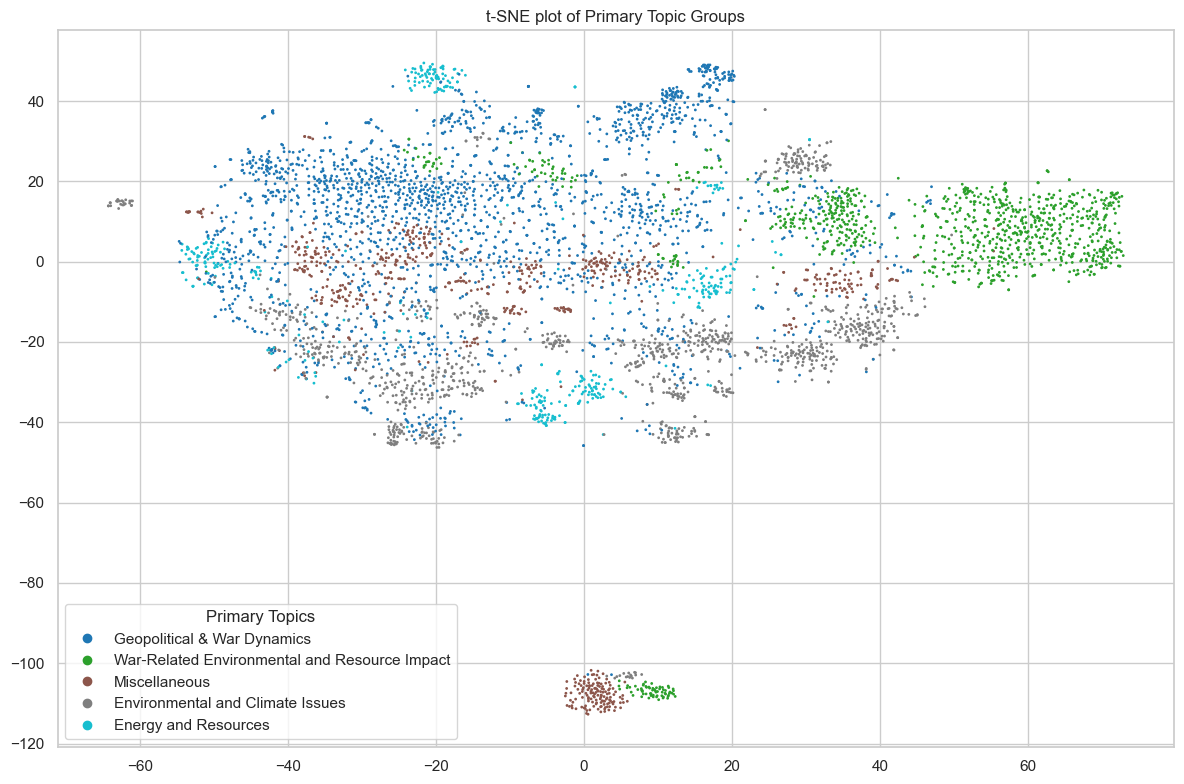

In [92]:
# Set the Seaborn style and Matplotlib figure resolution
sns.set(style="whitegrid")
plt.figure(dpi=300)

# Plot the result
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=primary_topic_factor, cmap='tab10', s=1)
# plt.legend(*scatter.legend_elements(), title="Digits")
# Generate legend elements
legend_elements, _ = scatter.legend_elements()
# Create legend labels from the mapping
legend_labels = [primary_topic_mapping_dict[i] for i in np.unique(primary_topic_factor)]

# Create the legend with the mapped labels
plt.legend(handles=legend_elements, labels=legend_labels, title="Primary Topics")
plt.title('t-SNE plot of Primary Topic Groups')

# Save the figure with high resolution
plt.tight_layout()
plt.savefig("figures/t-SNE-primary-groups.png", dpi=300)

plt.show()

In [7]:
from bertopic import BERTopic
import json
bertopic_model = BERTopic.load('bertopic-model/bertopic-fasttext64-custom-embeddings-all-data/')
bertopic_data = pd.read_parquet('all-data-feb-2025-bertopic-topics-on-reactions-corpus-merged.parquet')

/Users/Taras_Ustyianovych/workspace/python-envs/lda-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-13 10:10:06,973 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.
